In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sun Feb  1 17:06:40 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00000000

In [2]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [4]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [46]:
from ad_afqmc import linalg_utils
from jax import lax
import jax
from jax import numpy as jnp

# @jit
# def uwalker_norm(
#     walker_up: jax.Array,
#     walker_dn: jax.Array,
# ) -> float:
#     norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
#         ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
#     return jnp.real(norm)


# @jit
# def qr_walker_uhf(walker_up, walker_dn):
#     nocc_up = walker_up.shape[1]
#     nocc_dn = walker_dn.shape[1]
#     q_up, r_up = jnp.linalg.qr(walker_up)
#     q_dn, r_dn = jnp.linalg.qr(walker_dn)
#     norm_up = jnp.sqrt(
#         jnp.real(
#             jnp.linalg.det(r_up[:,:nocc_up].conj().T @ r_up[:,:nocc_up])
#             )
#         )
#     norm_dn = jnp.sqrt(
#         jnp.real(
#             jnp.linalg.det(r_dn[:,:nocc_dn].conj().T @ r_dn[:,:nocc_dn])
#             )
#         )
#     return (q_up, q_dn), norm_up * norm_dn

# def qr_walkers_uhf(walkers):
#     (walkers_up, walkers_dn), norms \
#         = vmap(qr_walker_uhf, in_axes=(0, 0))(walkers[0], walkers[1])
#     return (walkers_up, walkers_dn), norms

@jit
def stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers, dtype=jnp.complex128) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    
    # prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    # weights = jnp.real(norms[0] * norms[1])
    # nwalker = int(prop_data["weights"].shape[0])
    # prop_data["weights"] *= weights
    # prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    # prop_data["weights"] *= prop_data["overlaps"]
    # prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data


# @partial(jit, static_argnums=(3))
# def fp_step(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     return prop_data, fields

# @partial(jit, static_argnums=(3))
# def fp_step_qr(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     (prop_data["walkers"][0], prop_data["walkers"][1]), norms \
#         = qr_walkers_uhf(prop_data["walkers"])
#     nwalker = int(prop_data["weights"].shape[0])
#     prop_data["weights"] *= norms 
#     prop_data["weights"] /= nwalker * jnp.sum(prop_data["weights"])
#     return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_qr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_sr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["weights"] *= prop_data["overlaps"]
    prop_data["key"], subkey = random.split(prop_data["key"])
    zeta = random.uniform(subkey)
    prop_data["walkers"], prop_data["weights"] \
        = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["weights"] /= prop_data["overlaps"]
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data, fields

# @partial(jit, static_argnums=(2, 3, 5))
# def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
#     """free propagation for a block of (n_prop_steps, n_walkers)."""
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     fields = random.normal(
#         subkey,
#         shape=(
#             sampler.n_prop_steps,
#             prop.n_walkers,
#             ham_data["chol"].shape[0],
#         ),
#     )
#     _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
#     prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

#     prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
#     energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
#     energy_samples = jnp.where(
#         jnp.abs(energy_samples - prop_data["e_estimate"]
#                 ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
#                 energy_samples)
#     block_energy = jnp.sum(
#         energy_samples * prop_data["weights"] * prop_data["overlaps"] 
#         ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
#     block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
#     return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )

    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    block_weight = jnp.sum(jnp.abs(prop_data["overlaps"]) * jnp.abs(prop_data["weights"]))
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * jnp.abs(prop_data["overlaps"]) * jnp.abs(prop_data["weights"])
        ) / jnp.sum(jnp.abs(prop_data["overlaps"]) * jnp.abs(prop_data["weights"]))
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs2(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    block_weight = jnp.sum(jnp.abs(prop_data["overlaps"] * prop_data["weights"]))
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * jnp.abs(prop_data["overlaps"] * prop_data["weights"])
        ) / jnp.sum(jnp.abs(prop_data["overlaps"] * prop_data["weights"]))
    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_srabs2(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    block_energy = jnp.sum(
        energy_samples * jnp.abs(prop_data["overlaps"] * prop_data["weights"])
        ) / jnp.sum(jnp.abs(prop_data["overlaps"] * prop_data["weights"]))
    
    block_weight = jnp.sum(jnp.abs(prop_data["overlaps"] * prop_data["weights"]))

    return prop_data, (block_energy, block_weight)

In [26]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    # prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844824


In [27]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 60
fp_qr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_qr_e[0] = prop_data["e_estimate"]
fp_qr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_qr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_qr_e[n+1] = blk_e
    fp_qr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.6142771795268+0.001029966591097587j) (-320.5397789914845+0.7872791639047942j)
2 (-108.63717808093571+0.00011565389425826976j) (-175.26224199786844+0.8702265066454897j)
3 (-108.6549628338546+0.008071383210537809j) (-195.93247811999592-1.3438047312151502j)
4 (-108.68154066361728+0.00793360848242947j) (268.1452283089152+2.360208037491195j)
5 (-108.63124045922214-0.0100166220323833j) (-178.34458362392493+5.3189306785137624j)
6 (-108.63076751229772-0.006071800068278727j) (-178.91366192083476+5.924676854925783j)
7 (-108.63999735507943-0.01868761995561126j) (-126.0507106809614+7.80711343472532j)
8 (-108.62276562845767-0.011868806159322173j) (-161.55507302360363+7.205844547170427j)
9 (-108.64695091099134+0.004159162902395198j) (222.57187135324756-8.11766183602985j)
10 (-108.62803681387923-0.006839141738410111j) (237.11832153684185-7.02499202594543j)
11 (-108.65919159980206-0.011503416959565558j) (898.2522979261037-83.08795440198193j)
12 (-108.66542830415652+0.002287469190940805j) (-166

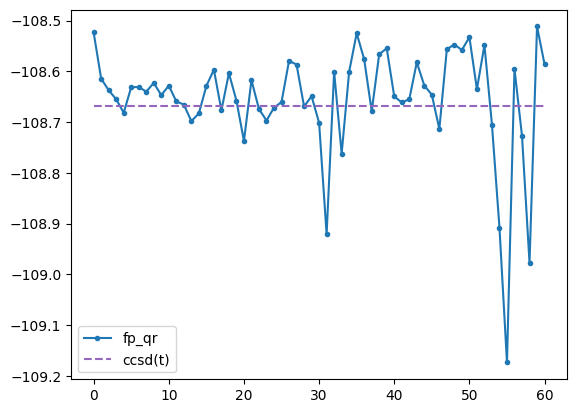

In [28]:
from matplotlib import pyplot as plt

plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot([mycc.e_tot + et]*len(fp_qr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [12]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.6152881863107-0.0013499349152236097j) (214.23728277507666+2.2900699940828533e-17j)
2 (-108.61631812856515+0.0058965025913574j) (188.49429744307156+1.990257995007503e-17j)
3 (-108.63825662229748+0.010529003501253216j) (829.4981513890168+4.167720915189985e-15j)
4 (-108.65284918761937+0.0033247874259840007j) (181.52503277757486+4.984216608710151e-16j)
5 (-108.60875817917676+0.00409125357541809j) (309.8999585043848-1.085515305910597e-15j)
6 (-108.62852955540318-0.002909636339869602j) (150.9596391905718+5.480284347105177e-16j)
7 (-108.61776893623062-0.0033805278744777133j) (58.361972006896025-3.1253748952244294e-16j)
8 (-108.60774273109898-0.008495205428884708j) (244.12065069559742+4.264547752722619e-16j)
9 (-108.78053531232597-0.015005417187844608j) (130.95914216876855-7.647898498891914e-17j)
10 (-108.67300102600046+0.014671918224132092j) (129.35235810245803-5.008797834872523e-16j)
11 (-108.64228123758464-0.005718493554643477j) (217.84043417282737+8.251601223939841e-16j)
12 (-108.6

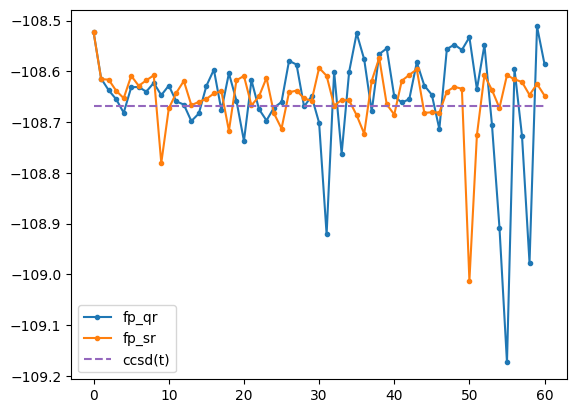

In [13]:
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [47]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_abs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs_e[0] = prop_data["e_estimate"]
fp_abs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs_e[n+1] = blk_e
    fp_abs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61388523467757+0.0011670219494637245j) 320.72727769543326
2 (-108.63579724114253+0.000797965369105831j) 175.70406352093926
3 (-108.65062446928842+0.010114845668215123j) 197.74014022660015
4 (-108.6768735039259+0.008884878746910718j) 271.8705080941641
5 (-108.62316645734873-0.0076739516385345005j) 183.08485146391888
6 (-108.62078655697502-0.006346776457106308j) 184.70330735232864
7 (-108.6233713690939+0.00525525898348594j) 133.38724412852716
8 (-108.60502798274862-0.015630521274125012j) 171.11953535023403
9 (-108.63799265097292+0.0001594412166301824j) 234.694912116002
10 (-108.62377222504375-0.010514573553756798j) 247.286237400664
11 (-108.64759982855243-0.007350817608814266j) 948.60186973465
12 (-108.64746460234475+0.013501703182680947j) 177.82584527031884
13 (-108.66717944811836+0.028877340088854255j) 191.7765970293122
14 (-108.65262862199286+0.048640182483344105j) 86.07453878312525
15 (-108.61290490462915+0.0269172291346379j) 127.74276838742232
16 (-108.58375214593183+0.01965

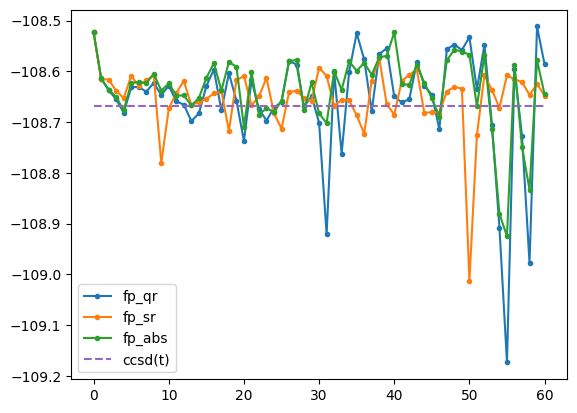

In [48]:
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [37]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_abs2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_abs2_e[0] = prop_data["e_estimate"]
fp_abs2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_abs2(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_abs2_e[n+1] = blk_e
    fp_abs2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61388523467757+0.001167021949463725j) 320.72727769543326
2 (-108.63579724114255+0.0007979653691058305j) 175.70406352093926
3 (-108.65062446928843+0.010114845668215125j) 197.74014022660012
4 (-108.67687350392589+0.008884878746910716j) 271.87050809416417
5 (-108.62316645734873-0.007673951638534501j) 183.08485146391888
6 (-108.62078655697502-0.006346776457106308j) 184.70330735232864
7 (-108.62337136909392+0.005255258983485941j) 133.38724412852713
8 (-108.60502798274862-0.015630521274125012j) 171.11953535023403
9 (-108.63799265097292+0.00015944121663018335j) 234.694912116002
10 (-108.62377222504377-0.010514573553756798j) 247.286237400664
11 (-108.64759982855243-0.007350817608814267j) 948.60186973465
12 (-108.64746460234475+0.013501703182680949j) 177.82584527031884
13 (-108.66717944811835+0.028877340088854255j) 191.7765970293122
14 (-108.65262862199287+0.04864018248334411j) 86.07453878312523
15 (-108.61290490462916+0.0269172291346379j) 127.7427683874223
16 (-108.5837521459318+0.0196

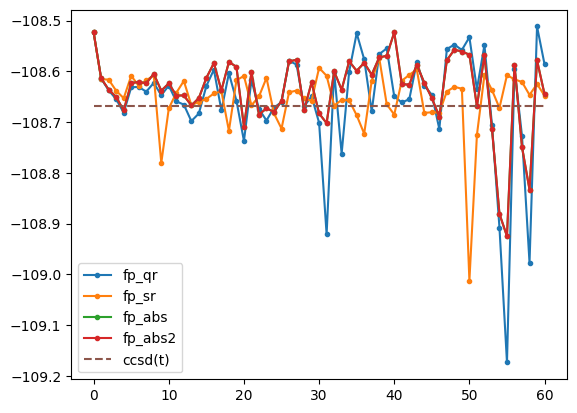

In [39]:
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot(fp_abs2_e.real,'.-',label='fp_abs2',color='C3')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C5')
plt.legend()
plt.show()

In [34]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_srabs_e = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs_w = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs_e[0] = prop_data["e_estimate"]
fp_srabs_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_srabs(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_srabs_e[n+1] = blk_e
    fp_srabs_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.6152881863107-0.0013499349152237229j) 214.23728277507666
2 (-108.61631812856517+0.0058965025913575156j) 188.49429744307156
3 (-108.63825662229748+0.010529003501253154j) 829.4981513890168
4 (-108.65284918761938+0.003324787425984161j) 181.52503277757484
5 (-108.60875817917675+0.0040912535754181285j) 309.8999585043848
6 (-108.62852955540315-0.0029096363398697553j) 150.9596391905718
7 (-108.61776893623062-0.003380527874477657j) 58.361972006896025
8 (-108.60774273109897-0.008495205428884954j) 244.12065069559742
9 (-108.78053531232598-0.015005417187844492j) 130.95914216876855
10 (-108.67300102600046+0.01467191822413278j) 129.35235810245803
11 (-108.64228123758464-0.005718493554643549j) 217.84043417282737
12 (-108.6189239145989+0.01616619298190471j) 1256.5501623320636
13 (-108.66659184271329+0.014069431310399694j) 1740.245434375297
14 (-108.66010887225177-0.01977373870924418j) 325.6255618341403
15 (-108.65431752373624+0.003118061003884531j) 120.8349772648607
16 (-108.6435977075355+0.0

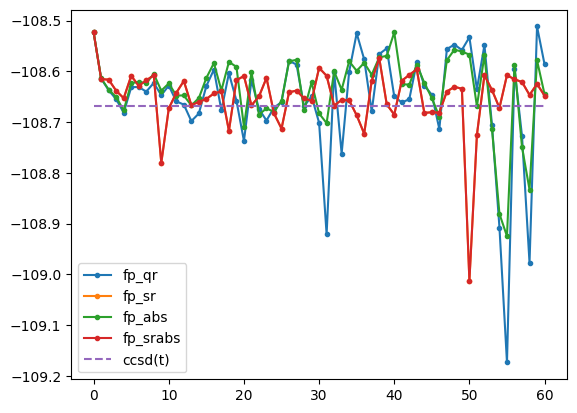

In [35]:
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot(fp_srabs_e.real,'.-',label='fp_srabs',color='C3')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [41]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_srabs2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_srabs2_e[0] = prop_data["e_estimate"]
fp_srabs2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_srabs2(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_srabs2_e[n+1] = blk_e
    fp_srabs2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.6152881863107-0.0013499349152237248j) 214.23728277507666
2 (-108.61631812856518+0.0058965025913575156j) 188.4942974430715
3 (-108.63825662229748+0.010529003501253159j) 829.4981513890168
4 (-108.65284918761934+0.0033247874259841634j) 181.52503277757486
5 (-108.60875817917679+0.004091253575418126j) 309.89995850438476
6 (-108.62852955540318-0.0029096363398697545j) 150.9596391905718
7 (-108.61776893623062-0.0033805278744776547j) 58.361972006896025
8 (-108.60774273109897-0.008495205428884952j) 244.12065069559742
9 (-108.78053531232598-0.015005417187844492j) 130.95914216876855
10 (-108.67300102600046+0.01467191822413278j) 129.35235810245803
11 (-108.64228123758461-0.005718493554643546j) 217.84043417282737
12 (-108.61892391459891+0.016166192981904706j) 1256.5501623320633
13 (-108.66659184271332+0.014069431310399698j) 1740.2454343752966
14 (-108.66010887225181-0.019773738709244187j) 325.6255618341402
15 (-108.65431752373622+0.0031180610038845317j) 120.8349772648607
16 (-108.64359770753

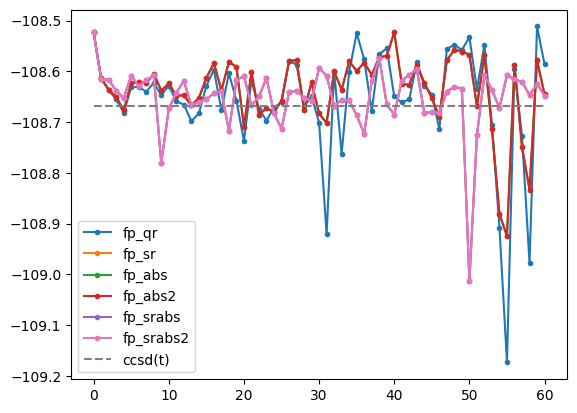

In [45]:
plt.plot(fp_qr_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot(fp_abs_e.real,'.-',label='fp_abs',color='C2')
plt.plot(fp_abs2_e.real,'.-',label='fp_abs2',color='C3')
plt.plot(fp_srabs_e.real,'.-',label='fp_srabs',color='C4')
plt.plot(fp_srabs2_e.real,'.-',label='fp_srabs2',color='C6')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C7')
plt.legend()
plt.show()